# CSCI 3202, Fall 2021: Final Coding Exam

---


This practicum is due on Moodle by **11:59 PM on Sunday December 12**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.

**The rules:**

1. Choose any TWO of the following three problems to submit. Note the problems that you are submitting below. If you do not choose two problems, the graders will grade the first 2 problems by default. The graders WILL NOT grade all three problems and pick the 2 highest scores. So it is your responsibility to clearly indicate the TWO problems you are choosing.

**I choose Problem 1 and Problem 2**

1. All work, code and analysis must be **your own**.
1. You may use your course notes, posted lecture slides, textbook, in-class notebooks and homework solutions as resources.  You may also search online for answers to general knowledge questions, like the form of a probability distribution function, or how to perform a particular operation in Python.
1. You may **not** post to message boards or other online resources asking for help.
1. **You may not collaborate with classmates or anyone else.**
1. This is meant to be like a coding portion of your final exam. So, I will be much less helpful than I typically am with homework. For example, I will not check answers, help debug your code, and so on.
1. If you have a question, post it first as a **private** Piazza message. If I decide that it is appropriate for the entire class, then I will make it a public post (and anonymous).
1. If something is left open-ended, it is probably because I intend for you to code it up however you want, and only care about the plots/analysis I see at the end. Feel free to ask clarifying questions though.

Violation of these rules will result in an **F** and a trip to the Honor Code council.

---
**By writing your name below, you agree to abide by these rules:**

**Your name:** Jack Kapushion

---



In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors



---
## [50 pts] Problem 1:  Route-finding

Consider the map of the area to the west of the Engineering Center given below, with a fairly coarse Cartesian grid superimposed.

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/engineering_center_grid_zoom.png" style="width: 800px;"/>

The green square at $(x,y)=(1,15)$ is the starting location, and you would like to walk from there to the yellow square at $(25,9)$ with the **shortest total path length**. The filled-in blue squares are obstacles, and you cannot walk through those locations.  You also cannot walk outside of this grid.

Legal moves in the North/South/East/West directions have a step cost of 1. Moves in the diagonal direction (for example, from $(1,15)$ to $(2,14)$) are allowed, but they have a step cost of $\sqrt{2}$. 

Of course, you can probably do this problem (and likely have to some degree, in your head) without a search algorithm. But that will hopefully provide a useful "sanity check" for your answer.

#### Part A
Write a function `adjacent_states(state)`:
* takes a single argument `state`, which is a tuple representing a valid state in this state space
* returns in some form the states reachable from `state` and the step costs. How exactly you do this is up to you. One possible format for what this function returns is a dictionary with the keys being the tuple locations and the values of the keys being the step costs. E.g: adjacent_states((1,1)) =  $\{(2,1):1, (2,2):1.414\}$

Print to the screen the output for `adjacent_states((1,15))`.

In [2]:
# Your code here.

# helper to construct a box in the environment
def builder(bottomLeftCorner, dimensions, env):
    for i in range(dimensions[0]):
        for j in range(dimensions[1]):
            env[i + bottomLeftCorner[0]][j + bottomLeftCorner[1]] = 1

# building environment
env = np.zeros((16,25), int) # array of zeros
builder((10,20), (6,5), env) # top right square
builder((8,9), (4,4), env) # middle squares
builder((10,11), (4,4), env) # middle squares
builder((0,4), (1,19), env) # bottom line
builder((1,0), (13,1), env) # base of pyramid
builder((2,1), (11,1), env) # layers of pyramid...
builder((3,2), (9,1), env)
builder((4,3), (7,1), env)

def adjacent_states(state):
    adjacents = []
    diagonal = 0
    for i in range(-1,2,1):
        for j in range(-1,2,1):
            diagonal += 1
            if state[0]+i <= 15 and state[0]+i >= 0 and state[1]+j <= 24 and state[1]+j >= 0:
                neighbor = (state[0]+i, state[1]+j)
                if env[neighbor[0]][neighbor[1]] != 1 and neighbor != state:
                    if diagonal % 2 == 1:
                        adjacents.append((neighbor, 1.414))
                    else:
                        adjacents.append((neighbor, 1))
    return adjacents

#### Part B
Three candidate heuristic functions might be:
1. `heuristic_cols(state, goal)` = number of columns between the argument `state` and the `goal`
1. `heuristic_rows(state, goal)` = number of rows between the argument `state` and the `goal`
1. `heuristic_eucl(state, goal)` = Euclidean distance between the argument `state` and the `goal`

Write a function `heuristic_max(state, goal)` that returns the maximum of all three of these heuristic functions for a given `state` and `goal`.

In [3]:
# Your code here.
def hueristic_max(state, goal):
    def hueristic_cols(state, goal):
        return np.abs(goal[1] - state[1])
    def hueristic_rows(state, goal):
        return np.abs(goal[0] - state[0])
    def hueristic_euc(state, goal):
        return np.sqrt(np.square(goal[1] - state[1]) + np.square(goal[0] - state[0]))
    return round(max(hueristic_cols(state, goal), hueristic_rows(state, goal), hueristic_euc(state, goal)), 3)

#### Part C
Is the Manhattan distance an admissible heuristic function for this problem?  Explain why or why not.

The manhatten huersitic would not be admissible becuase it can overestimate the goal. This is becuase the agent in this problem can move diagnonally. "Stair stepping" will cost more than traveling diagnonally. Moving from (1,1) to (2,2) will cost 2 for the manhatten distance and cost 1.414 to travel diagnonally. 

#### Part D
Use A\* search and the `heuristic_max` heuristic to find the shortest path from the initial state at $(1,15)$ to the goal state at $(25,9)$. Your search **should not** build up the entire state space graph in memory. Instead, use the `adjacent_states` function from Part A.

In [4]:
# frontier will be in the form of a priority queue
class frontierPQ:
    # frontier will be a list containing tuples with a state, path to that state and a path cost
    def __init__(self, path = None):
        self.lst = [path]
        
    # adds path to frontier and then reorders from least cost to greatest
    def append(self, path):
        self.lst.append(path)
        sortedLst = sorted(self.lst, key=lambda x: x[2]) 
        self.lst = sortedLst
        
    # returns true if given path is in the frontier and false otherwise
    def contains(self, path):
        for s in self.lst:
            if s[0][0] == path: return True
        return False
    
    # returns first (least path cost) path and removes it from queue
    def pop(self):
        return self.lst.pop(0)
    
    # returns tuple containing data for desired state
    def getPath(self, state):
        for s in self.lst:
            if s[0] == state: return s
        

def astarSearch(start, goal, env, hueristic):
    # frontier object will contain a list of tuples with a state, path to that state and a path cost
    frontier = frontierPQ((start, [start], hueristic(start, goal)))
    # explored will be a list of explored states
    explored = []
    # while frontier not empty
    while frontier.lst: 
        path = frontier.pop()
        state = path[0]
        if state == goal: 
            return path[1]
        explored.append(state)
        # explores all neighbors of current state
        for neighbor in adjacent_states(state):
            # cost = cost of path without hueristic + cost to get to neighbor + hueristic of neighbor
            cost = round((path[2] - hueristic(state, goal)) + neighbor[1] + hueristic(neighbor[0], goal), 3)
            # if neighbor not in explored and not in frontier
            if (neighbor[0] not in explored) and (frontier.contains(neighbor[0]) == False):
                newPath = path[1].copy()
                newPath.append(neighbor[0])
                frontier.append((neighbor[0], newPath, cost))
            # if neighbor is in frontier and current path is less costly than original
            elif (frontier.contains(neighbor[0])) and (frontier.getPath(neighbor[0])[2] > cost):
                # replaces the more costly route with less costly route
                newPath = path[1].copy()
                newPath.append(neighbor[0])
                frontier.lst.remove(frontier.getPath(neighbor[0]))
                frontier.append((neighbor[0], newPath, cost))
    # if function exits while loop, no path was found            
    print("No path found")
    return

#### Part E
Make a figure depicting the optimal route from the initial state to the goal, similarly to how you depicted the maze solution in Homework 2.

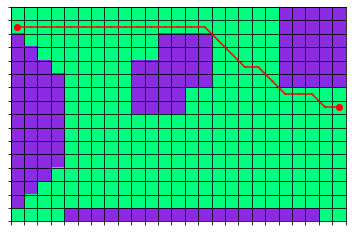

In [5]:
# Your code here.
def plot_maze(env, path, start, goal):
    
    nrow, ncol = env.shape
    
    # create colormap
    cmap = colors.ListedColormap(['springgreen', 'blueviolet'])

    fig, ax = plt.subplots()
    ax.imshow(env, cmap=cmap, origin='lower')
    
    # draw gridlines
    ax.grid(which='major', axis='both', linestyle='-', color='k')
    ax.set_xticks(np.arange(-.5, ncol, 1))
    ax.set_yticks(np.arange(-.5, nrow, 1))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    
    if path:
        for p in range(len(path)-1):
            point = path[p]
            nextpoint = path[p+1]
            plt.plot([point[1],nextpoint[1]], [point[0],nextpoint[0]], c='red')
        plt.scatter(start[1],start[0], color = 'red') # start
        plt.scatter(goal[1],goal[0], color = 'red') # end
    
    plt.show()
    
plot_maze(env, astarSearch((14,0), (8,24), env, hueristic_max), (14,0), (8,24))



---
## [50 pts] Problem 2:  Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if I say the drone is at $(x,y,z)$ I mean that it is in the box centered at $(x,y,z)$. And there are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. So, for example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, which is just a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, which is a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the heck that landing pad is, and how to get there from any initial state.

In [6]:
# Your code here.
class MDPLanding:
    def __init__(self, L, default_reward, discount):
        # states represent all positions in a 3D box
        self.states = [(x,y,z) for x in range(0,L+1) for y in range(0,L+1) for z in range(0,L+1)]
        # terminal states are all states where z = 0
        self.terminalStates = [(x,y,0) for x in range(0,L+1) for y in range(0,L+1)]
        self.defaultReward = default_reward
        self.discount = discount
        self.L = L
    
    def actions(self, state):
        actions = []
        # trys going down first because the bottom is where all the valuable info is
        if (state[0], state[1], state[2]-1) in self.states: # Down
            actions.append((state[0], state[1], state[2]-1))
        if (state[0]+1, state[1], state[2]) in self.states: # East
            actions.append((state[0]+1, state[1], state[2]))
        if (state[0]-1, state[1], state[2]) in self.states: # West
            actions.append((state[0]-1, state[1], state[2]))
        if (state[0], state[1]+1, state[2]) in self.states: # North
            actions.append((state[0], state[1]+1, state[2]))
        if (state[0], state[1]-1, state[2]) in self.states: # South
            actions.append((state[0], state[1]-1, state[2]))
        if (state[0], state[1], state[2]+1) in self.states: # Up
            actions.append((state[0], state[1], state[2]+1))
        return actions
    
    def reward(self, state):
        if state in self.terminalStates:
            if state == (self.L/2, self.L/2, 0): return 1
            else: return -1
        else: return -0.01
        
    def randomNonTerminalState(self):
        s = (0,0,0)
        while s in self.terminalStates:
            s = self.states[np.random.choice(len(self.states))]
        return s
        

#### Part B
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case (so 125 total states).

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and comment on the results:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

In [7]:

def policyIteration(state, env, tol):
    
    newU = {}
    maxChange = 0
    
    for initS in env.states:
            newU[initS] = env.reward(initS)

    while True:
        oldU = newU.copy()
        maxChange = 0
        for s in env.states:
            if s not in env.terminalStates:
                bestU = -np.inf
                for a in env.actions(s):
                    if oldU[a] > bestU:
                        bestU = oldU[a]
                newU[s] = env.reward(s) + env.discount * bestU
                maxChange = max(maxChange, abs(oldU[s]-newU[s]))
        if maxChange < tol:
            break
    
    bestU = 0
    for action in env.actions(state):
        if newU[action] > bestU:
            bestU = newU[action]
            bestAction = action
    
    return bestAction


PIenv = MDPLanding(L = 4, default_reward = -0.01, discount = .999)
print((2,2,1), ' --> ', policyIteration((2,2,1), PIenv, .01))
print((0,2,1), ' --> ', policyIteration((0,2,1), PIenv, .01))
print((2,0,1), ' --> ', policyIteration((2,0,1), PIenv, .01))

(2, 2, 1)  -->  (2, 2, 0)
(0, 2, 1)  -->  (1, 2, 1)
(2, 0, 1)  -->  (2, 1, 1)


This problem was kinda weird becuase it involved the methods from the homework 5 policy/value iteration but with no probabilities. It ended up working in a more simple way. My function outputs the values I was expecting. The (2,2,1) is right above the landing pad and it coorectly went down one space. The other two states are above terminal states and coorectly chose not to go down into them and instead move closer to the landing pad before moving down. 

#### Part C

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values (see Section 22.3 in the textbook - page 803 might be of particular interest).  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. I refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets in Part D below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [8]:
# Your code here.
import time

def QlearningAlgo(env, episodes):
    # initialize Q and N dicts and cumulative reward list
    Q = {}
    N = {}
    cumulativeReward = []
    
    # fill all dictionary values with 0
    for initS in env.states:
        for initA in env.actions(initS):
            Q[initS,initA] = 0
            N[initS,initA] = 0
    
    # run episodes
    for e in range(episodes):
        
        # extend cumulativeReward list
        cumulativeReward.append(0)
        
        # generate random state that is not a terminal state
        s = env.randomNonTerminalState()

        # run episode for 50 time steps
        start = time.time()
        timeSteps = 50
        while time.time() < start + timeSteps:
            
            # pick best action from s based on Q values
            # effectively moves the drone into state a
            bestQ = -np.inf
            for action in env.actions(s):
                if Q[s,action] > bestQ:
                    bestQ = Q[s,action]
                    a = action

            # calcluate exploratory motivator:
            # increment number of visits to state a from state s.
            # explore decreases as N[s,a] increases.
            # explore provides a consequence for visiting states many times.
            N[s,a] += 1
            explore = 1 / N[s,a]

            # find maximum Q value in current state a's actions
            # how good of a position is the drone now in?
            bestNextQ = -np.inf 
            for aPrime in env.actions(a):
                bestNextQ = max(bestNextQ, Q[a,aPrime])

            # update Q value:
            # previous value of moving from s to a + the new learned value of moving from s to a
            Q[s,a] = Q[s,a] + explore * (env.reward(a) + (env.discount * bestNextQ) - Q[s,a])

            # record ammount of time passed in this episode
            currentTimeStep = time.time() - start
            
            # cumulative reward = discount * the reward of the current state
            # as currentTimeStep increases, the discount will decrease which will decrease reward more.
            # as time passes, the rewards become more discounted. achieving goal sooner is more valuble than later. pretty cool.
            cumulativeReward[e] += (env.discount**currentTimeStep) * env.reward(a)
            
            # if drone is in a terminal state (landed), episode is over
            if a in env.terminalStates:
                break
            
            # if drone still flying, set s to a and do it all over again
            s = a
    
    # return dict of Q values and list of cumulative rewards for each episode
    return Q,cumulativeReward


Creating environment and runnning the Q learning algo to train the drone:

In [9]:
env = MDPLanding(L = 10, default_reward = -0.01, discount = .999)
droneReportCard = QlearningAlgo(env, 5000)

Animation of drone using learned Q-values to land in coorect location:

In [11]:
# for some reason, this cell doesnt run when compiled with the whole notebook. If it is taking a long time, stop and start this cell over again and it should work.  

import matplotlib.animation as animation

# Returns a list of (x,y,z) tupels generated from your Q Learning product
def land_drone(s):
    Q = droneReportCard[0]
    path = []
    bestQ = -np.inf
    a = (1,1,1)
    while a not in env.terminalStates:
        for action in env.actions(s):
            if Q[s,action] > bestQ:
                bestQ = Q[s,action]
                a = action
        path.append(a)
        s = a
    return path

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

paths = [land_drone((env.randomNonTerminalState())) for _ in range(len(colors))]
longest = max(len(l) for l in paths)

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 90
fig = plt.figure()
fig.set_size_inches(8, 8)
lim = (0, 10)
ax = fig.add_subplot(111, projection='3d')
ax.set(xlim3d=lim, ylim3d=lim, zlim3d=lim, xlabel='x', ylabel='y', zlabel='z')

def animate(i):
    for idx, p in enumerate(paths):
        xs, ys, zs = zip(*p[:i+1])
        ax.plot3D(xs, ys, zs, color=colors[idx])

ani = animation.FuncAnimation(fig, animate, frames=longest)
plt.close()
ani

#### Part D

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your codes.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

Mean of last 5000 trials cumulative rewards:  0.7695604857184895


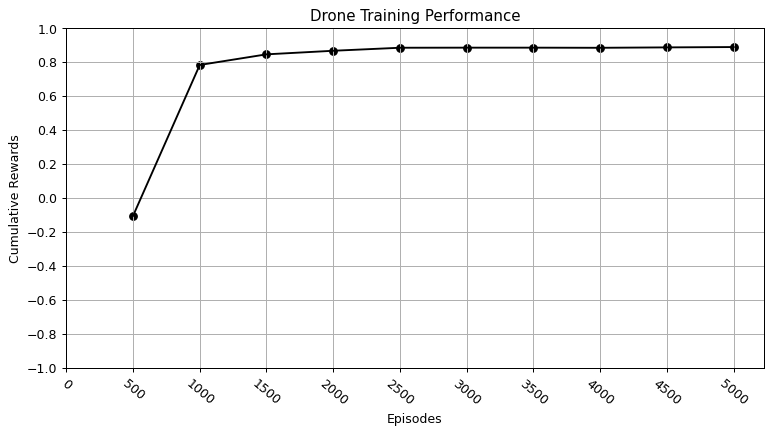

In [12]:

print('Mean of last 5000 trials cumulative rewards: ', np.mean(droneReportCard[1]))

blockMeans = np.array([])
episodes = np.array([])

for i in range(0, 5000, 500):
    blockMeans = np.append(blockMeans, np.mean(droneReportCard[1][i : i+499]))
    episodes = np.append(episodes, i+500)

df = pd.DataFrame(data=blockMeans, columns=['Cumulative Rewards'])
df['Episodes'] = episodes
df.head()

df.plot(x ='Episodes', y='Cumulative Rewards', kind = 'line', color = 'black')
plt.scatter(x = df['Episodes'], y= df['Cumulative Rewards'], color = 'black')
plt.title('Drone Training Performance')
plt.ylabel('Cumulative Rewards')
plt.grid(True)
plt.xticks(np.arange(0, 5500, 500), rotation=-40)
plt.yticks(np.arange(-1, 1.2, .2))
plt.gcf().set_size_inches(10, 5)
plt.legend().remove()
plt.show()


#### Part E

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training? <br>
In my tests, the cumulative reward starts off around -0.2. The cumulative reward starts off low becuase the drone has very little information at the start of training. On the first run, it has a very small chance of hitting the landing pad, which means it has a high probabilty of losing points. The point loss is reflected in the low starting cumulative rewards. Quickly after the first 500 trials, the drone is able to make much better decisions and this is why the drone's rewards dont start off at somthing even lower. 

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8? <br>
The drone starts off at a random location in the environment. Even if the drone takes the most optimal path, it will still lose points by traveling there. Using this algorithm to find the most optimal path from every location will take many more episodes than used in these tests. In each iteration, the drone will lose points travleing to the landing pad and also lose points by taking sub optimal turns. The point loss associated with the journey to the landing pad will limit the drone from achiving rewards much larger than .8. 

---

## [50 points] Problem 3:  Calibrating a model for global mean sea level changes

<img src="http://www.anthropocenemagazine.org/wp-content/uploads/2017/05/future-sea-levels.jpg" width="250">



**Part A:** Load and plot some data.

Let's load a couple data sets.  `data_sealevel.csv` is a data set of global mean sea levels, and the other, `data_temperature.csv` is a data set of global mean temperatures. The following bullets discuss the quantities of interest. 
* `sealevel` will be a list of global mean sea levels (millimeters). This data is found in a column which resides within the `data_sealevel.csv`
* `sealevel_sigma` will be a list of the *uncertainty* in global mean sea levels (millimeters). Use the column labeled `uncertainty` within the `data_sealevel.csv` file to obtain this data, and
* `temperature` will be a list of global mean temperatures (degrees Celsius). This data is in the `temperature` column in the `data_temperature.csv` file



In [ ]:
# Here is the suggested code to load in the data files. Feel free to modify these as you wish, but that
# is not necessary.

year = []
sealevel = []
sealevel_sigma = []
temperature = []

dfSealevel = pd.read_csv("data_sealevel.csv")
dfTemperature = pd.read_csv("data_temperature.csv")

# We aren't doing any heavy-duty stats stuff, so let's just keep what we need as regular lists
year = dfSealevel["year"].tolist()
sealevel = dfSealevel["sealevel"].tolist()
sealevel_sigma = dfSealevel["uncertainty"].tolist()
temperature = dfTemperature["temperature"].tolist()

**Part A (i):**

- Make three plots for Global mean surface temperature, Sea level (mm), and Sea Level Uncertainty (mm). The x-axis for each of these plots will be the years over which this data was collected. 

- Plot the data points as a scatter plots, and plot the three plots side-by-side-by-side (one row, three columns of figures). The point here is learn how to customize your figures a bit more, and also because computer screens are (typically) wider than they are tall.

In [ ]:
# Your plotting code here.

**Part A (ii):** How does the uncertainty in global mean sea levels change as a function of time?  When is the uncertainty the highest?  Give one reason why you think this might be the case.

---

**Part B:**  The "out-of-box" sea-level model

In your plot from **(a)**, you should see quite an apparent relationship between increasing temperatures and rising sea levels.  Seeems like someone should try to model the relationship between those two, huh?

In the helper function, slr, below, a simple model for temperature-driven changes in global mean sea level (GMSL) is defined. This is the model of [Rahmstorf (2007)](http://science.sciencemag.org/content/315/5810/368).

The `slr` model takes two parameters, $\alpha$ and $T_{eq}$, and requires a time series of global mean temperatures: `slr(alpha, Teq, temperature)`.
* `alpha` is the sensitivity of sea-level changes to changes in global temperature. The units for $\alpha$ are millimeters of sea-level changes per year, or mm y$^{-1}$.
* `Teq` is the equilibrium global mean temperature, with units of degrees Celsius.
* `temperature` is the time series of global mean surface temperatures, assumed to be relative to the 1961-1990 mean.

For now, you do not need to worry too much about how this model works.  It is very simple, and widely used, but the point here is that you can plug in a particular set of temperatures (the model **forcing**) and parameters ($\alpha$ and $T_{eq}$), and out pops a time series of simulated global mean sea levels.

**Our goal:**  pick good values for $\alpha$ and $T_{eq}$, so that when we run the `slr` model using the observations of temperature (which we plotted above), the model output matches well the observations of global mean sea level (which we also plotted above).

The whole process of figuring out what these good parameter values are is called **model calibration**, and it's awesome.  Model Calibration is the point of this problem. Let's have a look at why we need to do this in the first place, shall we?

The default parameter choices given in the Rahmstorf (2007) paper are $\alpha=3.4$ mm y$^{-1}$ and $T_{eq} = -0.5\ ^{\circ}$C.

**Your task for Part B:**

Make a plot that contains:
* the observed sea level data as scatter points
* the modeled sea levels as a line, using the temperature observations from above as the `temperature` input
* an appropriate legend and axis labels
* $x$ axis is years
* $y$ axis is sea level

Note that after you run the `slr` model, you will need to **normalize** the output relative to the 1961-1990 reference period.  That is because you are going to compare it against data that is also normalized against this reference period. The `years` that correspond to the model output should be the same as the `years` that correspond to the `temperature` input. Normalizing data can mean several things. Follow the steps outlined below to "normalize" the data in the way needed for this problem:
- Compute the mean of the output of the slr model for the years from 1961-1990 (inclusive).
- Subtract this value from each entry in the "sealevel" list (list returned by the slr function)


Make sure that you normalize the data prior to plotting.

In [ ]:
# helpers

def slr(alpha, Teq, temperature):
    '''sea-level emulator of Rahmstorf 2007 (DOI: 10.1126/science.1135456)
    Takes global mean temperature as forcing, and parameters:
    alpha = temperature sensitivity of sea level rise, and
    Teq   = equilibrium temperature,
    and calculates a rise/fall in sea levels, based on whether the temperature
    is warmer/cooler than the equilibrium temperature Teq.
    Here, we are only worrying about alpha (for now!)'''

    n_time = len(temperature)
    deltat = 1
    sealevel = [0]*n_time
    sealevel[0] = -134
    for t in range(n_time-1):
        sealevel[t+1] = sealevel[t] + deltat*alpha*(temperature[t]-Teq)

    return sealevel




In [ ]:
# Your code here.

Your plot above ought to show decent match for the late 1900s, but diverge a bit further back in time.

**The point:**  We can do better than this "out-of-the-box" version of the Rahmstorf sea level model.

**Part C:**   Figuring out our objective function

As our **objective function**, we will use the joint likelihood function of the observed sea level data, given the model simulation.  The following is a detailed description of the derivation of the objective funciton for a hill climbing routine. **Note, you do not need to do anything for this part other than to read about the objective function and execute the cell below, then move to part D.**

For a single data point in year $i$, $y_i$, with associated uncertainty $\sigma_i$, we can assume the likelihood for our model simulation in year $i$, $\eta_i$, follows a normal distribution centered at the data point.  The model simulation is a **deterministic** result of our parameter choices $\alpha$ and $T_{eq}$, so we write the likelihood as:

$$L(y_i \mid \alpha, T_{eq}) = \dfrac{1}{\sqrt{2 \pi} \sigma_i} e^{-\dfrac{(\eta_i(\alpha, T_{eq}) - y_i)^2}{2\sigma_i^2}}$$

But that only uses a single data point.  Let's use all the data!  The **joint likelihood** is the product of all of the likelihoods associated with the individual data points. But that is the product of a lot of numbers that are less than 1, so it will be **tiny**.  Instead, we should try to optimize the **joint log-likelihood**, which is simply the (natural) logarithm of the joint likelihood function.

If we assume the observational data ($y_i$) are all independent, then the joint log-likelihood is:

$$l(\mathbf{y} \mid \alpha, T_{eq}) = -\dfrac{N}{2} \log{(2\pi)} - \sum_{i=1}^N \log{(\sigma_i)} - \dfrac{1}{2}\sum_{i=1}^N \left( \dfrac{\eta_i(\alpha, T_{eq}) - y_i}{\sigma_i} \right)^2$$

where, $\mathbf{y} = [y_1, y_2, \ldots, y_N]$ is the entire vector (list) of sea level observations, $\eta(\alpha, T_{eq}) = [\eta_1(\alpha, T_{eq}), \eta_2(\alpha, T_{eq}), \ldots, \eta_N(\alpha, T_{eq})]$ is the entire vector (list) of `slr` model output when the parameter values $\alpha$ and $T_{eq}$ are used, and $N$ is the number of observations we have.


**Defining our objective function**

Now define a `log_likelihood(parameters, obs_mu, obs_sigma)` function:
* `parameters`: argument that is a list of two parameter values, $[\alpha, T_{eq}]$
  * within the likelihood function, you will need to generate the model simulation $\eta(\alpha, T_{eq})$ using the input `parameters`, for comparison against the observational data
* `obs_temp`: argument that is a time series (list) of observed global mean temperatures, that will be used to run the `slr` model. Provide a default value of `temperature` for this, because we only have one temperature data set to use, and we don't want to keep 
* `obs_mu`: argument that is a time series (list) of observed values, that will be used for comparison against the `model` output. Provide a default value of `sealevel` here, because we won't be changing the observational data.
* `obs_sigma`: argument that is a time series (list) of the corresponding uncertainties in the observational data. Simiarly, provide a default value of `sealevel_sigma` here, so we can avoid the tedious task of sending the data set into this function.
* all three of these inputs should be lists, and should be the same length
* this routine should return a **single** float number, that is the joint log-likelihood of the given `model` simulation.

In [ ]:
# Here is the objective function. You will be using this function below when you code up hill-climbing and 
# simulated annealing routines.

def log_likelihood(parameters, obs_temp=temperature, obs_mu=sealevel, obs_sigma=sealevel_sigma):
    model = slr(alpha=parameters[0], Teq=parameters[1], temperature=temperature)
    
    # normalize
    reference = (year.index(1961), year.index(1990))
    model -= np.mean(model[reference[0]:(reference[1]+1)])

    return np.sum([np.log(stats.norm.pdf(x=model, loc=obs_mu, scale=obs_sigma))])

**Part D:**  Defining our class structure

Now we will apply a hill-climbing algorithm to tune the $\alpha$ and $T_{eq}$ parameters.

Using our in-class lecture notebook on hill-climbing as a guide, do the following:

* Define a `State` class, with attributes for the parameter values (which define the state) and the objective function value of that state.
* Define a `Problem_hillclimb` **sub-class** of the more general class `Problem`, with:
  * attributes for the current `State` (a `State` object), the `objective_function` (the log-likelihood defined above), and `stepsize`. You will need to play around to decide what an appropriate stepsize is. Keep in mind that you may need a different stepsize for each of $\alpha$ and $T_{eq}$.
  * methods for `moves` (return the list of all possible moves from the current state) and `best_move` (return the move that maximizes the objective function).
  * the `moves` available should be in proper 2-dimensional space.  Do **not** simply optimize one parameter, keeping the other fixed, then optimize the other parameter, while keeping the first fixed.  (*That method *can* work, but there are some theoretical issues that would need to be tackled, and we are not getting into that here.*) You are allowed to restrict yourself to movements along a grid, as long as you entertain steps in both the $\alpha$ and the $T_{eq}$ directions.
* Define the `hill_climb` algorithm, with any necessary modifications (here, and in the above classes) for the new 2-dimensional state space.
  * `hill_climb(problem, n_iter)`:  arguments are a `Problem_hillclimb` object and number of iterations, `n_iter`
  * return a `State` that corresponds to the algorithm's guess at a global maximum

In [ ]:
# Your code here.

Now:
1. define an initial state object, using the default values from Rahmstorf 2007 as a starting point.
2. define a hill-climbing problem object, using this initial state, the log-likelihood objective function, and stepsize(s) of your choosing. (The stepsize(s) may require some playing around to find something you are happy with.)
3. ***hill-climb!!!*** Use a number of iterations that you deem appropriate. 

Play around until you have a simulation that you are happy with.  Then:
1. Print to screen the parameter values and corresponding log-likelihood value.
2. Compare this calibrated log-likelihood value to the "out-of-box" model (above).
3. Make a plot of:
  * the sea level observations as scatter points
  * the uncalibrated model as one line
  * the calibrated model as another line
  * include axis labels and a legend
  
**"Unit tests":**
* As a benchmark, make sure that your log-likelihood is *at least* -500.
* Your calibrated (optimized) model simulation should be going straight through the data points.
* If this isn't the case, remember to normalize your model against the 1961-1990 reference period!

In [ ]:
# Your code here.

**Part E:**  Simulated annealing

Let's re-calibrate the `slr` model. This time, we will use **simulated annealing**. Again, using our in-class activity as a guide, do the following:

* Continue to use your `State` class above.
* Define a `Problem_annealing` sub-class of the `Problem` class, with:
  * attributes for the current `State` (a `State` object), the `objective_function` (the log-likelihood defined above), and `stepsize`. You will need to play around to decide what an appropriate stepsize is. Keep in mind that you may need a different stepsize for each of $\alpha$ and $T_{eq}$.
  * method for `random_move`, to pick a random move **by drawing from a multivariate normal distribution**.  You should use the `stepsize` attribute as the covariance (width) for this.
* Define the `simulated_annealing` algorithm, with any necessary modifications (here, and in the above classes) for the new 2-dimensional state space.
  * `simulated_annealing(problem, n_iter)`:  arguments are a `Problem_annealing` object and number of iterations, `n_iter`
  * return a `State` that corresponds to the algorithm's guess at a global maximum

Subject to the above constraints, you may implement these however you would like.

In [ ]:
# Your code here.

Now:
1. define an initial state object, using the default values from Rahmstorf 2007 as a starting point.
2. define a simulated annealing problem object, using this initial state, the log-likelihood objective function, an appropriate temperature updating schedule and stepsize(s) of your choosing. (The stepsize(s) may require some playing around to find something you are happy with.)
  * note that this "temperature" is distinct from the actual physical temperature used as input to drive the `slr` model
3. ***anneal!!!*** Use a number of iterations that you deem appropriate. 

Play around until you have a simulation that you are happy with.  Then:
1. Print to screen the parameter values and corresponding log-likelihood value.
2. Compare this calibrated log-likelihood value to the "out-of-box" model (above).
3. Make a plot of:
  * the sea level observations as scatter points
  * the uncalibrated model as one line
  * the calibrated model as another line
  * include axis labels and a legend
  
**"Unit tests":**  How does your model look when you plot it against the data? If it doesn't look good, then you failed this unit test :(

In [ ]:
# Your code here.

**Part F:**

Briefly summarize your findings. Specifically discuss the $\alpha$ and $T_{eq}$ parameter values you found in **Part D** and **Part E**. How do these compare to the parameters of the model given by Rahmstorf? Did your hill-climbing and/or your simulated annealing programs find a better fit than the Rahmstorf model? 